# Discrete return mapping - symbolic

In [1]:
import sympy as sp
sp.init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Material parameters

In [2]:
E_b = sp.Symbol('E_b', real=True, nonnegative=True)
gamma = sp.Symbol('gamma', real=True, nonnegative=True)
K = sp.Symbol('K', real=True)
S = sp.Symbol('S', real=True)
r = sp.Symbol('r', real=True)
c = sp.Symbol('c', real=True)
tau_bar = sp.Symbol(r'\bar{\tau}', real=True, nonnegative=True)
m = sp.Symbol('m', real=True)

In [3]:
material_params = {
    E_b:1, gamma:0., K:0., S:0.005, r:0.001, c:1, 
    tau_bar:1, 
    m:0 
}

In [4]:
material_params = {
    E_b:1, 
    gamma: 0.6, 
    K:1, 
    S:0.6, 
    r:0.001, 
    c:1, 
    tau_bar:1, 
}

## State variables

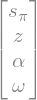

In [5]:
s = sp.Symbol('s', real=True)
omega = sp.Symbol('omega', real=True, nonnegative=True)
omega.is_nonnegative
s_pi = sp.Symbol(r's_pi', real=True)
alpha = sp.Symbol('alpha', real=True)
z = sp.Symbol('z', real=True)
Eta = sp.Matrix([s_pi, z, alpha, omega])
Eta

## Helmholtz potential

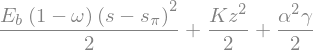

In [6]:
rho_psi = sp.Rational(1,2)* ( 
    (1-omega)*E_b*(s-s_pi)**2 + gamma * alpha**2 + K * z**2
)
rho_psi

## Thermodynamic forces

In [7]:
tau = sp.Symbol('tau', real=True)
tau_pi = sp.Symbol(r'tau_pi', real=True)
X = sp.Symbol('X', real=True)
Z = sp.Symbol('Z', real=True, nonnegative=True)
Y = sp.Symbol('Y', real=True)
Sigma = sp.Matrix([tau_pi, Z, X, Y])

In [8]:
grad_rho_psi = sp.Matrix([rho_psi.diff(eta) for eta in Eta])

In [9]:
Sigma_signs = sp.diag(1,-1,-1,1)

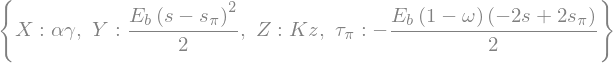

In [10]:
subs_Sigma_Eta = {
  var: val for var,val in zip(Sigma,-Sigma_signs*grad_rho_psi)
}
subs_Sigma_Eta

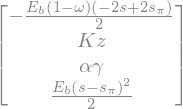

In [11]:
Sigma_Eta = -Sigma_signs*grad_rho_psi
Sigma_Eta

In [12]:
get_Sigma = sp.lambdify(
    (s, Eta), Sigma_Eta.subs(material_params), 'numpy'
)

## Threshold 

Define effective stresses as a function of the apparent stress and damage.  Note that $\tau_\pi = \tau$.

In [13]:
tau = sp.symbols(r'\tau')
tau_eff = sp.Function(r'\tau^{\mathrm{eff}}')(tau_pi, omega)
Q = sp.Function('Q')(tau_eff,X)
tau_eff

In [14]:
norm_Q = sp.sqrt(Q*Q)

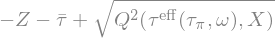

In [15]:
f = norm_Q - Z - tau_bar
f

In [16]:
subs_Q = {Q: tau_eff - X}

In [17]:
subs_tau_eff = {tau_eff: tau_pi / (1-omega)}

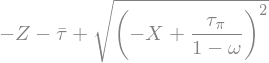

In [18]:
f_Sigma = f.subs(subs_Q).subs(subs_tau_eff)
f_Sigma

In [19]:
get_f_Sigma = sp.lambdify(
    (Eta, Sigma), f_Sigma.subs(material_params), 'numpy'
)

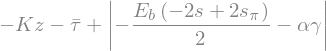

In [20]:
f_Eta = f_Sigma.subs(subs_Sigma_Eta)
f_Eta

**Normal directions to the yield surface:**
Define a generic operator getting the gradient from the specified stress norm, back stress an hardening stresses

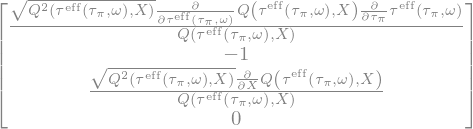

In [21]:
grad_f = f.diff(Sigma)
grad_f

**Stress normal directions:** with substituted stress norm and effective stress including damage

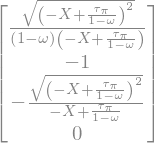

In [22]:
grad_f_Sigma = grad_f.subs(subs_Q).subs(subs_tau_eff).doit()
grad_f_Sigma

In [23]:
get_grad_f = sp.lambdify(
    (Sigma, Eta), grad_f_Sigma, 'numpy'
)

**Plot the threshold function**: for changing damage $\omega \in (0,1)$. 

In [24]:
def anim_levelset(get_f,
                  xrange=(-30,30), yrange=(-30, 30), zrange=(-30,30), trange=(0,1),
                  labels=['x','y','z'] ):
    xmin, xmax = xrange
    ymin, ymax = yrange
    zmin, zmax = zrange
    tmin, tmax = trange
    grid_args = np.mgrid[xmin:xmax:80j, ymin:ymax:80j, zmin:zmax:80j]
    f_args = tuple(grid_args)+(0.00001,)
    f_val = get_f(*f_args)
    contour = mlab.contour3d(
        *tuple(grid_args) + (f_val,),
        contours=[0.0], color=(1, 0, 0)
    )
    xl, yl, zl = labels
    mlab.axes(xlabel=xl, ylabel=yl, zlabel=zl)
    @mlab.animate
    def anim():
        for omega_val in np.linspace(tmin,tmax,100):
            contour.mlab_source.scalars = get_f(*tuple(grid_args)+(omega_val,))
            yield

    anim()
    mlab.show()

In [25]:
if False:
    subs_f_TF_data = ({m:0, tau_bar:10})
    get_f = sp.lambdify(
        (tau_pi, X, Z, omega), 
        f_TF.subs(subs_f_TF_data), 'numpy')
    anim_levelset(get_f)

## Flow potential

In [26]:
Phi = sp.Function('\phi')(Y,omega)

In [27]:
subs_Phi = {Phi: S* (1-omega)**c / (r+1) * (Y/S)**(r+1)}

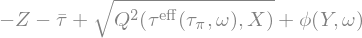

In [28]:
phi = f + Phi
phi

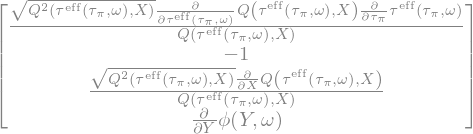

In [29]:
d_phi = phi.diff(Sigma)
d_phi

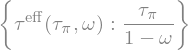

In [30]:
subs_tau_eff

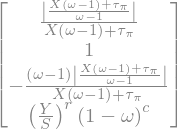

In [31]:
d_phi_Sigma = Sigma_signs * d_phi.subs(subs_Q).subs(subs_tau_eff).subs(subs_Phi).doit()
sp.simplify(d_phi_Sigma)

# Time integration scheme

## Time function for nonuniform load

In [32]:
t, theta = sp.symbols(r't, \theta')
n_cycles = 5
A = 2
ups = np.array([((theta-2*cycle)*A+(1-A), theta-2*cycle<=1) 
                for cycle in range(n_cycles)])
downs = np.array([((1-(theta-(2*cycle+1)))*A+(1-A),(theta-(2*cycle+1))<=1) 
                  for cycle in range(n_cycles)])
ups[0,0] = theta
updowns = np.einsum('ijk->jik',np.array([ups, downs])).reshape(-1,2)
load_fn = sp.Piecewise(*updowns).subs(theta,t*n_cycles)

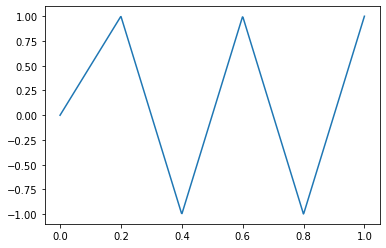

In [33]:
get_load_fn = sp.lambdify(t, load_fn,'numpy')
t_arr = np.linspace(0,1,600)
plt.plot(t_arr, get_load_fn(t_arr));

## Symbolic implementation

In [34]:
s_pi_k, z_k, alpha_k = sp.symbols(r's_pi_k, z_k, alpha_k', real=True)
s_pi_k1, z_k1, alpha_k1 = sp.symbols(r's_pi_k1, z_k1, alpha_k1', real=True)
omega_k, omega_k1 = sp.symbols(r'omega_k, omega_k1', real=True, nonnegative=True)
dlambda_ = sp.Symbol('lambda_Delta', nonnegative=True)

In [35]:
subs_Eta_k = {s_pi: s_pi_k, alpha: alpha_k, omega: omega_k, z: z_k }
subs_Eta_k1 = {s_pi: s_pi_k1, alpha: alpha_k1, omega: omega_k1, z: z_k1 }

In [36]:
Eta_k = sp.Matrix([sv.subs(subs_Eta_k) for sv in Eta])
Eta_k1 = sp.Matrix([sv.subs(subs_Eta_k1) for sv in Eta])

In [37]:
Eta_rates = dlambda_ * d_phi_Sigma.subs(subs_Sigma_Eta).subs(subs_Eta_k1)

In [38]:
Eta_k1_ =  Eta_k + Eta_rates
get_Eta_k1_ = sp.lambdify(
    (s, dlambda_, Eta_k, Eta_k1), Eta_k1_.subs(material_params), 'numpy'
)

In [39]:
subs_Eta_k1_ = {eta: expr for eta, expr in zip(Eta, list(Eta_k1_))}

In [40]:
f_Eta_k1_ = f_Eta.subs(subs_Eta_k1_)
get_f_Eta_k1_ = sp.lambdify(
    (s, dlambda_, Eta_k, Eta_k1), f_Eta_k1_.subs(material_params), 'numpy'
)

In [41]:
d_f_Eta_k1_ = f_Eta_k1_.diff(dlambda_)
get_d_f_Eta_k1_ = sp.lambdify(
    (s, dlambda_, Eta_k, Eta_k1), d_f_Eta_k1_.subs(material_params), 'numpy'
)

To define a generic return mapping we need to construct the  derivatives of the flow rule $f$ with respect to $\lambda$. The dependency of $\varphi$ on $\lambda$ is intermediated via thermodynamic forces $\tau$ and state variables $\eta$.   
\begin{align}
f(\tau(\eta(\lambda)), \eta(\lambda))
\end{align}
To reflect all dependencies, we need to apply both the composition of derivatives and the chain rule. Let us first recall that the composition rule renders the derivative with respect to $\eta$ of the form
\begin{align}
\partial_\eta f(\tau(\eta), \eta)
 &=
\partial_\tau f(\tau, \eta) \, \partial_\eta  \tau(\eta) + \partial_\eta f(\tau, \eta)
\end{align}
By expanding the derivatives of $\eta$ with respect to $\lambda$ we obtain
\begin{align}
\partial_\lambda f(\tau(\eta(\lambda)), \eta(\lambda))
 &=
\partial_\tau f(\tau, \eta) \, \partial_\eta  \tau(\eta) \partial_\lambda \eta + \partial_\eta f(\tau, \eta) \partial_\lambda \eta
\end{align}
and after collecting terms
\begin{align}
\partial_\lambda f(\tau(\eta(\lambda)), \eta(\lambda))
 &=
[
\partial_\tau f(\tau, \eta) \, \partial_\eta  \tau(\eta)  + \partial_\eta f(\tau, \eta)
] \,
\partial_\lambda  \eta
\end{align}

In [42]:
d_f_Sigma = f_Sigma.diff(Sigma)
d_Sigma_Eta = sp.Matrix([Sigma_Eta.T.diff(eta) for eta in Eta]).T
d_f_Eta = f_Sigma.diff(Eta)
d_f_Sigma_Eta = d_f_Sigma.T * d_Sigma_Eta + d_f_Eta.T
d_Eta_lambda = d_phi_Sigma
d_f_lambda = (d_f_Sigma_Eta * d_Eta_lambda)[0]

**Verification:** To check the result, let us substitute for $\tau$, then for $\eta^{j}$ and evaluate the derivative  

In [43]:
d_f_lambda_expanded = d_f_lambda.subs(subs_Sigma_Eta).subs(subs_Eta_k1_)
get_d_f_lambda_expanded = sp.lambdify(
    (s, dlambda_, Eta_k, Eta_k1), 
    d_f_lambda_expanded.subs(material_params), 'numpy'
)

In [47]:
Eta_0 = np.zeros((len(Eta),))
get_d_f_lambda_expanded(1.1, 0, Eta_0, Eta_0 )

Compare this value with the derived decomposed derivatives

In [53]:
d_Eta_lambda = d_phi_Sigma
d_f_lambda = (d_f_Sigma_Eta * d_Eta_lambda)[0]
get_d_f_lambda = sp.lambdify(
    (s, Sigma, Eta), d_f_lambda.subs(material_params), 'numpy'
)
Eta_0 = np.zeros((len(Eta),))
Sigma_0 = get_Sigma(1.1, Eta_0)
get_d_f_lambda(1.1, Sigma_0, Eta_0)

array([-2.6])

## Incremental fully implicit return mapping

In [54]:
def get_response( s_max=12.6, n_steps=2000, k_max=200, get_load_fn=lambda t: t):
    Eta_n, Eta_k = [np.zeros((len(Eta),), dtype=np.float_)for _ in range(2)]
    Eta_record, Sigma_record = [], []
    dlambda0 = 0
    k_max = 200
    t_arr = np.linspace(0,1.0,n_steps+1)
    s_t = s_max*get_load_fn(t_arr) + 1e-9
    for s_n in s_t: 
        f0 = get_f_Eta_k1_(s_n,dlambda0,Eta_n,Eta_k)
        norm_f0 = f0
        k = 0
        while k < k_max:
            if norm_f0 < 1e-3:
                Eta_n = np.copy(Eta_k)
                Sigma_n = get_Sigma(s_n,Eta_n).flatten()
                dlambda0 = 0
                Eta_record.append(Eta_n)
                Sigma_record.append(Sigma_n)
                break
            df0 = get_d_f_Eta_k1_(s_n,dlambda0,Eta_n, Eta_k)
            dlam = -f0/df0
            dlambda0 += dlam
            Eta_k = get_Eta_k1_(s_n, dlambda0, Eta_n, Eta_k).flatten()
            f0 = get_f_Eta_k1_(s_n, dlambda0, Eta_n, Eta_k)
            norm_f0 = np.fabs(f0)
            k +=1
        else:
            print('no convergence')
    return (t_arr, 
            s_t, 
            np.array(Eta_record,dtype=np.float_),
            np.array(Sigma_record,dtype=np.float_))

In [173]:
def plot_Eta_Sigma(Eta, Sigma):
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
    s_pi_, z_, alpha_, omega_ = Eta.T
    sig_pi_, Z_, X_, Y_ = Sigma.T
    n_steps = len(s_pi_)
    ax1.plot(s_t, sig_pi_, color='black', 
             label='n_steps = %g' % n_steps)
    ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$\tau$')
    ax1.legend()
    ax2.plot(t_arr, omega_, color='red', 
             label='n_steps = %g' % n_steps)
    ax2.set_xlabel('$s$'); ax2.set_ylabel(r'$\omega$')
    ax22 = ax2.twinx()
    ax22.plot(t_arr, Y_, '-.', color='red', 
             label='n_steps = %g' % n_steps)
    ax22.set_ylabel('$Y$')
    ax3.plot(t_arr, z_, color='green', 
             label='n_steps = %g' % n_steps)
    ax3.set_xlabel('$s$'); ax3.set_ylabel(r'$z$')
    ax33 = ax3.twinx()
    ax33.plot(t_arr, Z_, '-.', color='green')
    ax33.set_ylabel(r'$Z$')
    ax4.plot(t_arr, alpha_, color='blue', 
             label='n_steps = %g' % n_steps)
    ax4.set_xlabel('$s$'); ax4.set_ylabel(r'$Z$')
    ax44 = ax4.twinx()
    ax44.plot(t_arr, X_, '-.', color='blue')

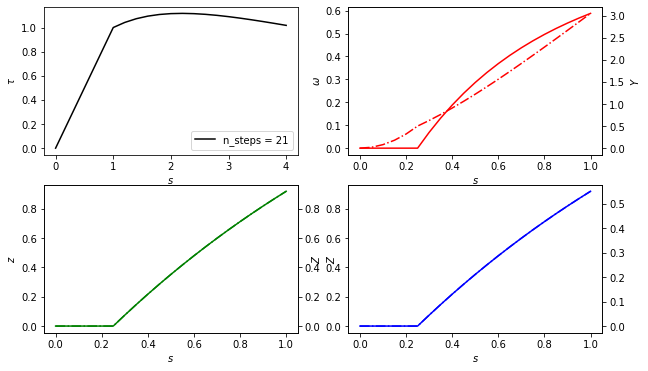

In [174]:
t_arr, s_t, Eta_arr, Sigma_arr = get_response(
    s_max=4, n_steps=20, k_max=50)
plot_Eta_Sigma(Eta_arr, Sigma_arr)

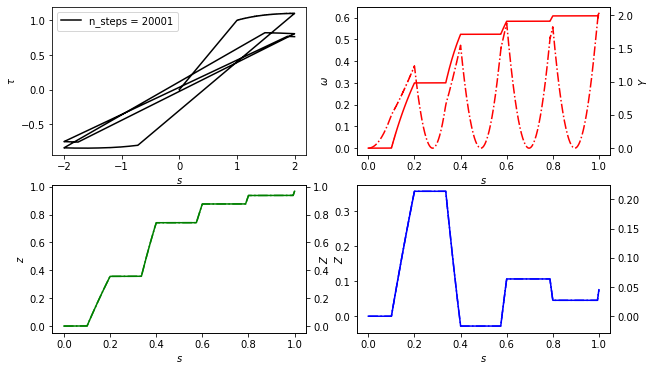

In [175]:
s_max = 2
t_arr, s_t, Eta_arr, Sigma_arr = get_response(
    s_max,20000,get_load_fn=get_load_fn)
plot_Eta_Sigma(Eta_arr, Sigma_arr)

In [176]:
from scipy.integrate import cumtrapz

In [183]:
def plot_work(ax, Eta_arr, Sigma_arr):
    W_arr = cumtrapz(Sigma_arr[:,0], s_t, initial=0)
    U_arr = Sigma_arr[:,0] * (s_t-Eta_arr[:,0]) / 2.0
    G_arr = W_arr - U_arr
    ax.plot(t_arr, W_arr, lw=2, color='black', label=r'$W$')
    ax.plot(t_arr, G_arr, color='black', label=r'$G$')
    ax.fill_between(t_arr, W_arr, G_arr, color='green', alpha=0.2)
    ax.set_xlabel('$s$'); ax3.set_ylabel(r'$E$')
    ax.legend()

In [186]:
sigma_signs = np.einsum('ii->i',np.array(Sigma_signs))
def plot_dissipation(ax, Eta_arr, Sigma_arr):    
    colors = ['blue','red', 'green', 'black', 'magenta' ]
    E_i = cumtrapz(Sigma_arr, Eta_arr, initial=0, axis=0)
    c = 'black'
    ax.plot(t_arr, E_i[:,0], '-.', lw=1, color=c)
    ax.fill_between(t_arr, E_i[:,0], 0, color=c, alpha=0.1)
    c = 'black'
    ax.plot(t_arr, E_i[:,0] + E_i[:,3], color=c, lw=1)
    ax.fill_between(t_arr, E_i[:,0] + E_i[:,3], E_i[:,0], 
                    color=c, alpha=0.2);
    c = 'blue'
    ax.plot(t_arr, E_i[:,1], '-.', lw=1, color='black')
    ax.fill_between(t_arr, E_i[:,1], 0, color=c, alpha=0.1)
    c = 'blue'
    ax.plot(t_arr, E_i[:,1] + E_i[:,2], color='black', lw=1)
    ax.fill_between(t_arr, E_i[:,1] + E_i[:,2], E_i[:,1], 
                    color=c, alpha=0.3);

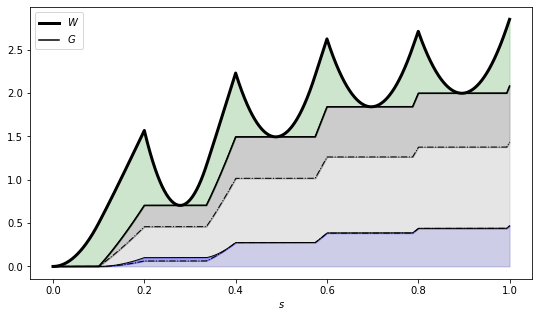

In [187]:
fig, ax = plt.subplots(1,1,figsize=(9, 5))
plot_work(ax, Eta_arr, Sigma_arr)
plot_dissipation(ax, Eta_arr, Sigma_arr)